### Aim/Object: 
To measure the geometry parameters from a sparse projection data set of a stack of beads.

In cone-beam tomography, the projections are distorted by the perspective the divergent
beam is producing. This means that geometry is essential to the successful
reconstruction of tomography. The center of rotation and the pixel size (this is only
needed to scale the attenuation coefficients) which is the only information required for
parallel beam reconstruction. For cone-beam reconstruction, you further need to know the
distances from the source to the sample (object), the distance from the source to the detector
(SDD). These parameters define the magnification of the configuration and would in
principle be sufficient for the reconstruction. The beam usually doesn’t hit the detector
perpendicularly, therefore we also need to know the position of the piercing point on the
detector px and py.


### Parameters needed for a clean reconstruction: 

1. COR - Center of Rotation 
2. CTilt - Tilt of the Rotation Axis
3. SOD - Source Object Distance
4. SDD - Source Detector Distance
5. PP - Piercing Point 

### Importing libraries and the py file containing all the functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as im
import sys
sys.path.append("../")
import amglib.readers as io
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import cbct
import importlib


E:\Kaestner\P20212680\01_scripts\CBCT\..\amglib\imageutils.py:8: FutureWarning: Importing from skimage.morphology.greyreconstruct is deprecated. Please import from skimage.morphology instead.
  import skimage.morphology.greyreconstruct as rec


### Loading the py file containing all the functions

In [239]:
importlib.reload(cbct)

<module 'cbct' from 'E:\\Kaestner\\P20212680\\01_scripts\\CBCT\\cbct.py'>

### Importing the dark current, open beam and projection images

In [6]:
datapath = '../../02_rawdata/00_Calibration/01_CBCTcal/'

In [7]:
dc=io.read_images(datapath+"dc_{:05}.fits",first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+"ob_{:05}.fits",first=1,last=10,averageStack=True,average='mean');
cal=io.read_images(datapath+"cbctcal_{:05}.fits",first=1,last=360,stride=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Visualizing a set of dark current, open beam and projection images

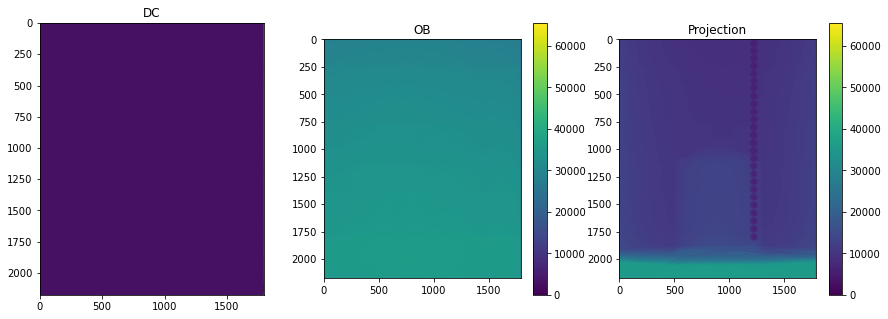

In [8]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(ob)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:]) #,vmin=0.0,vmax=10000)
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

### Normalization:    
The first step is to normalize the projections of the images using the dark current and the open beam images. Image texture is one of the very important factors for a good reconstruction. This is often distorted by the noise during scanning and other artifacts that may be present. Thus, we need to normalize the images. This is followed by flipping the image for an upright orientation. 


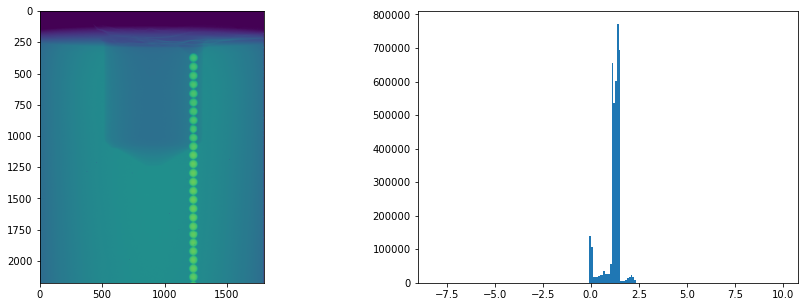

In [9]:
lcal=cbct.normalizeData(cal,ob,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,::-1,:]
    
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(lcal[1],vmin=0,vmax=3)
ax[1].hist(lcal[1].ravel(),bins=200);

### Cropping: 

The next step is to crop the image by converting the pixels of all unwanted elements into 0 such that they are not taken into consideration into the steps ahead for reconstruction. (This step is optional i.e depending on the magnification used, the extent of artifacts in the projection images varies depending on magnification used.)

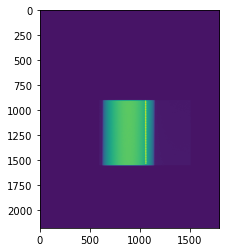

In [7]:
new_lcal=lcal.copy()
new_lcal[:,:,1500:]=0
new_lcal[:,:,:590]=0
new_lcal[:,1550:]=0
new_lcal[:,:900]=0


lcal=new_lcal
plt.imshow(new_lcal[1,:,:])

### Baseline Removal: 

This is followed by baseline removal such that only part left are the beads from the projection. This is done by setting an appropriate threshold to separate the rest of the image components from the beads and hence removing them by filtering them out. 

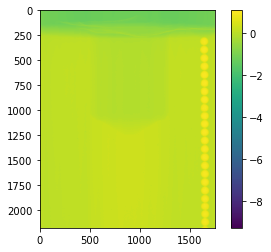

In [15]:
bcal=cbct.removeBaseline(lcal)
plt.imshow(bcal[10])
plt.colorbar()

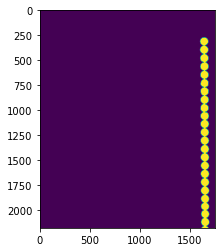

In [18]:
tcal=cbct.thresholdBBs(bcal,0.9)
plt.imshow(tcal[10])

### Watershed Segmentation -Visualization (Optional to run)
This is followed by erosion of the leftover beads to remove any excess noise close to the beads and then performing watershed fragmentation on them. 

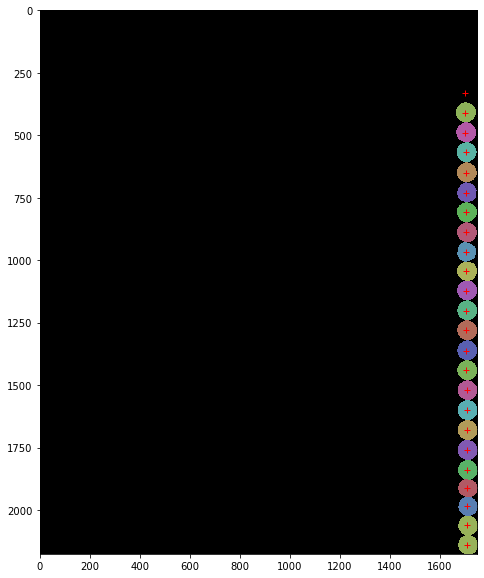

In [276]:
#optional- for visualization
importlib.reload(cbct)
cbct.watershed_segmentation_display(tcal[8])

### Identifying the trajectory of the ellipses: 


The next step is to identify the beads from the image of the segmented beads in order to track their trajectories across the many images taken. 
Method for bead detection deployed: 
- The centers of the watershed segmented beads are identified using skimage regionprops. 
- The centres obtained in the regionprops table are then converted to a 2D coordinate system form for easier understanding. 

This is followed by writing a function buildbeads that tracks the path of a specific bead across all the projects and stores the centres in an array for further processing.   

Once the trajectory of the beads has been identified, the aim is to find ellipses that best fit the paths. In some cases, the bead trajectories obtained are not optimum and hence, need to be dropped from this process since the ellipse identified corresponding to them would not be an accurate representation of the bead patten and hence may create errors in the calculation of tomography parameters ahead. The reason for these distorted bead trajectory can be attributed to the interference from other beads or the noise in the area of the beads.  

The ellipses’ parameters i.e center coordinate, the lengths of the major and minor axis, and the tilt in the ellipse orientation are calculated by using the EllipseModel() package by python to which the input parameter is the array containing the centers of specific beads across all the projects. 




In [277]:
importlib.reload(cbct)
beads = cbct.getBeads(tcal)

  0%|          | 0/36 [00:00<?, ?it/s]

In [278]:
e2,cog_allbeads,_=cbct.identifyEllipses(tcal)
print(e2)

  0%|          | 0/36 [00:00<?, ?it/s]

[[878.652052697349, 331.82804514715053, 826.5690654854444, 45.8347398460074, -0.0007491639107726095], [878.809197195779, 410.0133867570523, 824.6221653722123, 38.52304738041126, -0.0006108725197264686], [877.2736049947861, 490.1535524254284, 826.4998576108663, 29.42418689082689, -0.0006090252304113008], [865.4709336440468, 568.3657344882361, 827.2526880280693, 20.455374234097718, -0.0004860484578577129], [885.3488166931019, 649.8289142138403, 829.3676482125971, 11.10553394512979, -0.00045302315247708336], [897.6864390375031, 809.133175411307, 827.7031180798328, 7.266205379589605, -0.00015260186913762988], [875.1547884483012, 888.5578171649898, 828.8015737314951, 16.40256674696447, -0.0003760842563780142], [890.3532853640012, 966.761178041726, 826.2307097619246, 25.32732503731927, -0.0004002608498613569], [877.6454471408157, 1044.5720422985205, 827.5191598001994, 34.763399949050005, -0.0004267429268827172], [876.332395769346, 1120.6110285532825, 830.0532793178018, 43.08987490596282, -5.

In [279]:
len(e2)

21

ID Number =  0
center =  (878.652052697349, 331.82804514715053)
angle of rotation =  -0.0007491639107726095
axes major/minor =  826.5690654854444 45.8347398460074


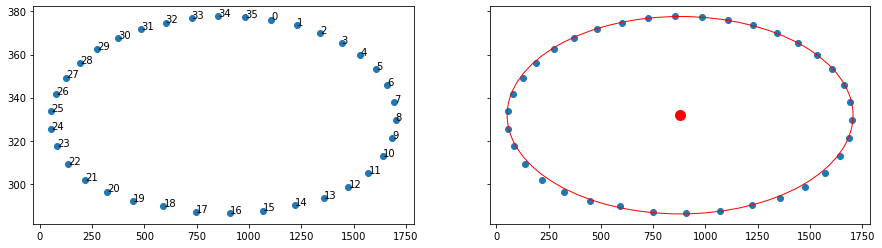

ID Number =  1
center =  (878.809197195779, 410.0133867570523)
angle of rotation =  -0.0006108725197264686
axes major/minor =  824.6221653722123 38.52304738041126


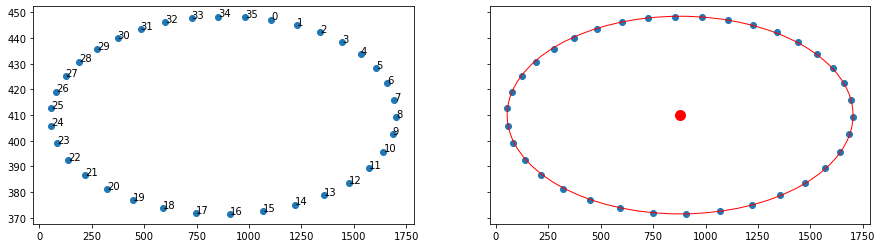

ID Number =  2
center =  (877.2736049947861, 490.1535524254284)
angle of rotation =  -0.0006090252304113008
axes major/minor =  826.4998576108663 29.42418689082689


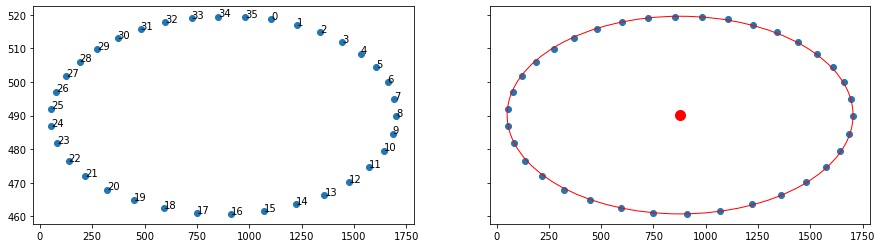

ID Number =  3
center =  (865.4709336440468, 568.3657344882361)
angle of rotation =  -0.0004860484578577129
axes major/minor =  827.2526880280693 20.455374234097718


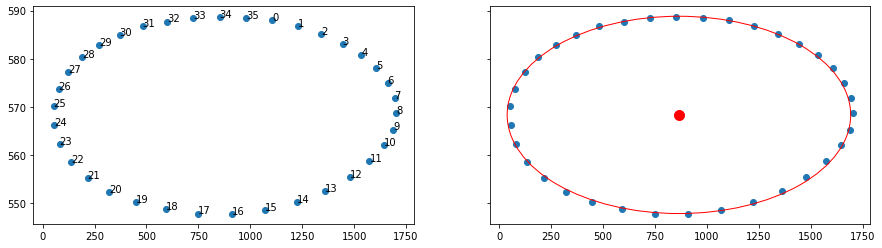

ID Number =  4
center =  (885.3488166931019, 649.8289142138403)
angle of rotation =  -0.00045302315247708336
axes major/minor =  829.3676482125971 11.10553394512979


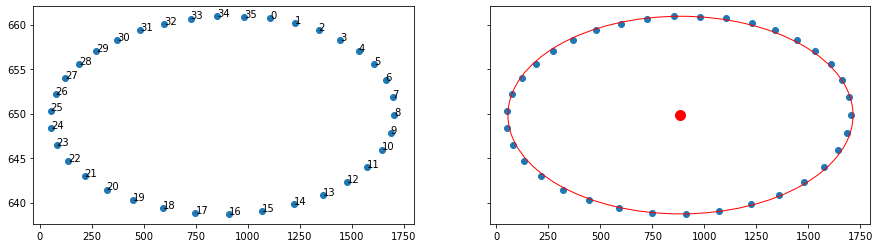

ID Number =  5
center =  (897.6864390375031, 809.133175411307)
angle of rotation =  -0.00015260186913762988
axes major/minor =  827.7031180798328 7.266205379589605


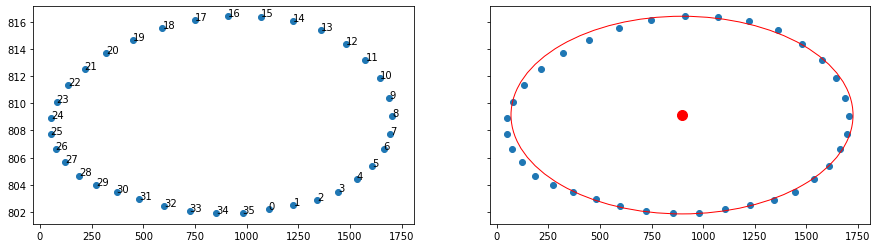

ID Number =  6
center =  (875.1547884483012, 888.5578171649898)
angle of rotation =  -0.0003760842563780142
axes major/minor =  828.8015737314951 16.40256674696447


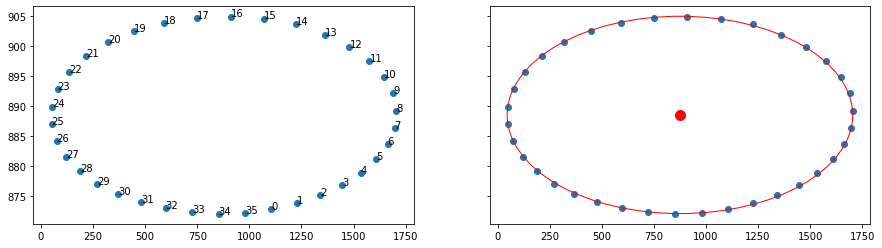

ID Number =  7
center =  (890.3532853640012, 966.761178041726)
angle of rotation =  -0.0004002608498613569
axes major/minor =  826.2307097619246 25.32732503731927


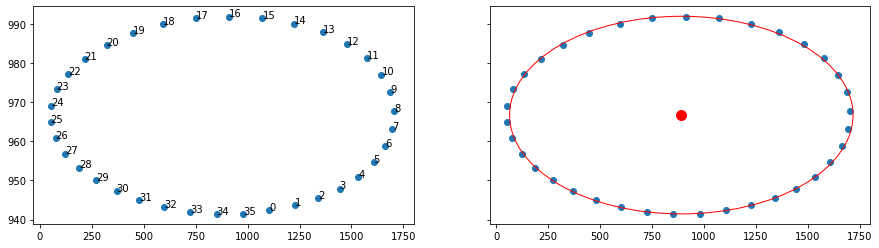

ID Number =  8
center =  (877.6454471408157, 1044.5720422985205)
angle of rotation =  -0.0004267429268827172
axes major/minor =  827.5191598001994 34.763399949050005


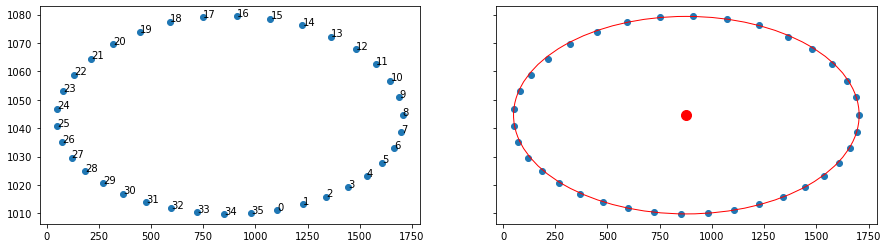

ID Number =  9
center =  (876.332395769346, 1120.6110285532825)
angle of rotation =  -5.043965286311014e-05
axes major/minor =  830.0532793178018 43.08987490596282


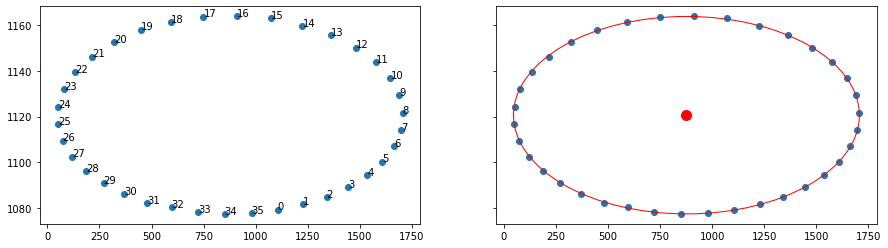

ID Number =  10
center =  (876.7863919413544, 1200.115660970634)
angle of rotation =  -0.00028429688599914863
axes major/minor =  829.9185142215205 52.14108395365235


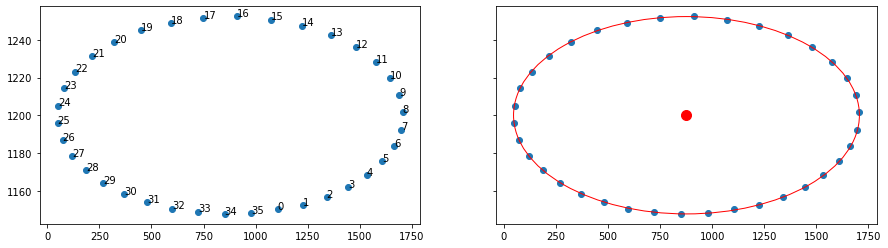

ID Number =  11
center =  (872.0954235442639, 1279.155315087664)
angle of rotation =  -0.0008418855466176822
axes major/minor =  835.1218601126282 61.57055090025415


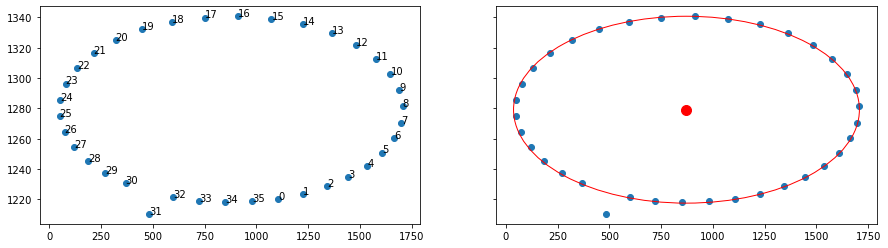

ID Number =  12
center =  (876.8197335743985, 1359.7136589217682)
angle of rotation =  -0.0001836178677083744
axes major/minor =  830.8840901234475 70.76269128042318


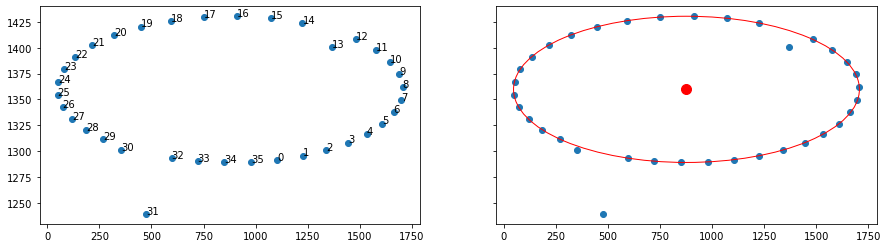

ID Number =  13
center =  (874.1901316687658, 1439.3477882209838)
angle of rotation =  0.0014783281767003376
axes major/minor =  827.9130051837113 79.31299461864565


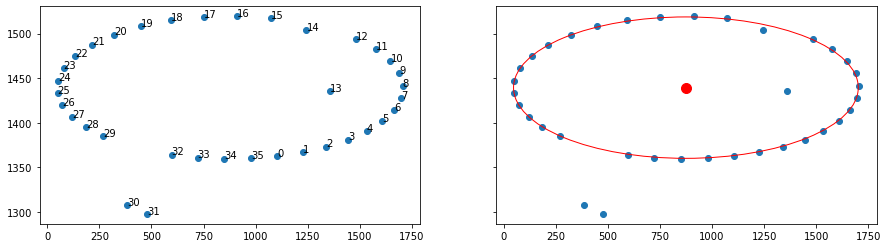

ID Number =  14
center =  (878.5033013436172, 1519.5978744778445)
angle of rotation =  -0.0003256989100304253
axes major/minor =  831.8779954714145 89.41587908391553


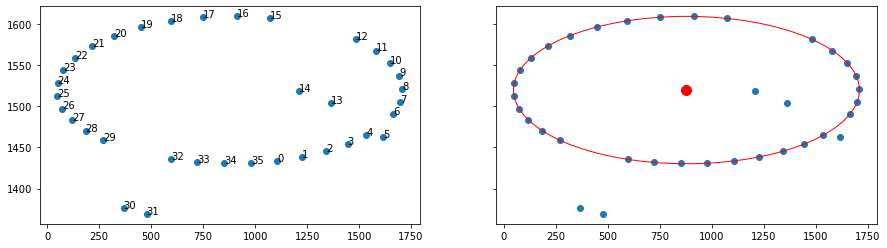

ID Number =  15
center =  (876.6420858909515, 1598.5203226845974)
angle of rotation =  -3.775434674668787e-05
axes major/minor =  830.9081911959518 98.46089371587647


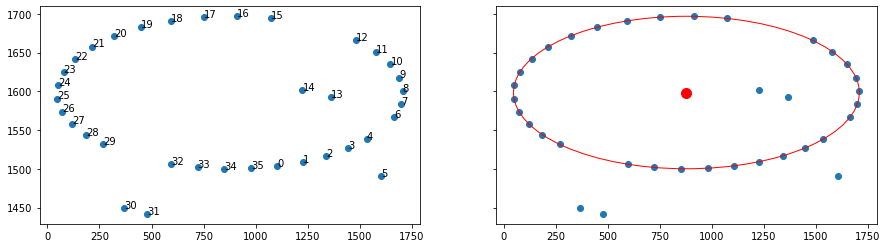

ID Number =  16
center =  (876.5154887431208, 1678.011791185217)
angle of rotation =  2.1964316097689007e-05
axes major/minor =  831.1709698902399 107.68887736588145


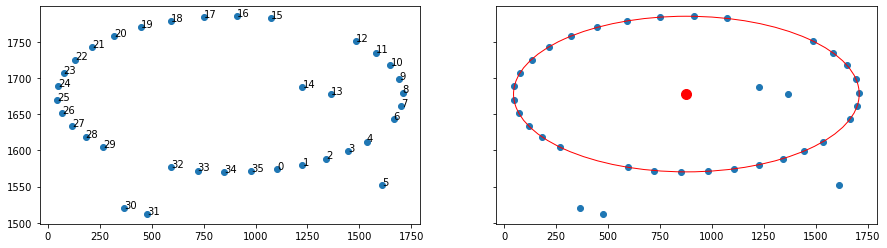

ID Number =  17
center =  (878.0417753182984, 1757.5614977913785)
angle of rotation =  3.6734083856959643e-06
axes major/minor =  832.4509922743879 116.82497118410681


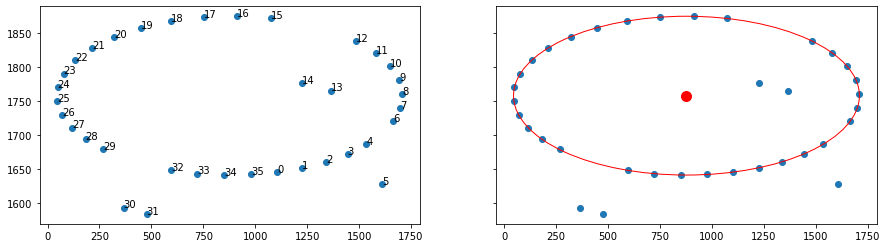

ID Number =  18
center =  (876.218700434571, 1837.299514965995)
angle of rotation =  0.0004077482676698718
axes major/minor =  832.1326908059649 126.07203461459818


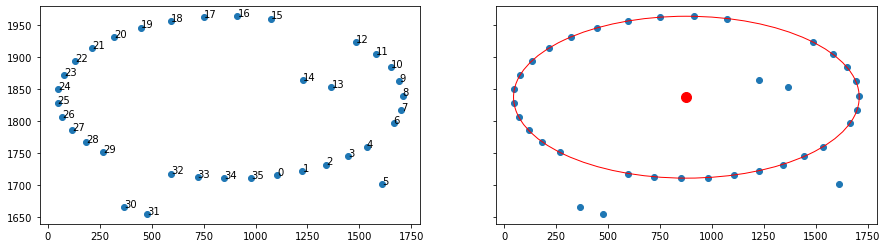

ID Number =  19
center =  (875.6250844297547, 1909.0865547266076)
angle of rotation =  0.000260191696355383
axes major/minor =  828.3659718586482 135.11320283221406


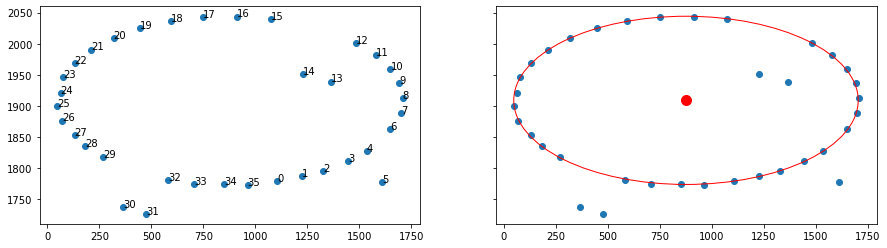

ID Number =  20
center =  (873.4529112720222, 1952.152993004479)
angle of rotation =  -1.2201143395174086e-05
axes major/minor =  851.3335102660592 176.84245340307098


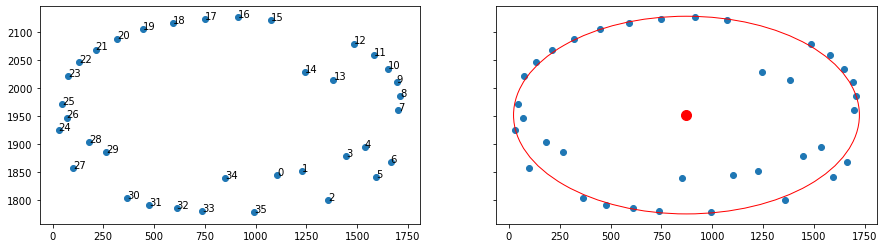

In [280]:
#optional to execute - it is for visualization of the ellipses plotted by the previous function 
cbct.show_ellipses(e2, cog_allbeads)

In [164]:
#deleting first few ellipses and beads due to distortion that occurs in their trajectory that may lead to erroneous calculations. 
del e2[20:]
del cog_allbeads[20:]

#### Structure of Array "e2":
#### [x-coordinate of the centre, 
#### y_coordinate of the centre, 
#### Length of the Major Axis, 
#### Length of the Minor Axis, 
#### Angular tilt of the ellipse]


### Estimating the Center of Rotation and its Tilt

The centre of rotation and tilt is calculated by using the best fit line for the center of all the trajectories of the beads through the multiple projections. 

A polynomial of degree 1 is approximated to fit the trend of the centres. The 2 main parameters obtained from the calculation give the tilt and the center of rotation axis coordinate. 

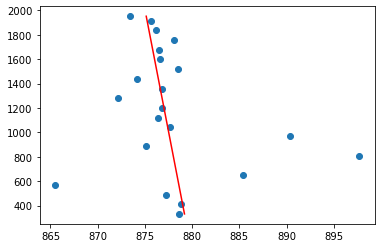

The parameters of the COR obtained are as follows: 880.0125369425797
The tilt of the center of rotation is in degrees:  -0.1431193230521559


{'COR': 880.0125369425797, 'Ctilt': -0.1431193230521559}

In [318]:
importlib.reload(cbct)
cbct.estimate_cor(e2)

In [314]:
880-27

853

### Estimating the Magnification

The magnification is calculated by using one of the projection images. The mean distance between the centres of the beads is calculated and then multiplied by the pixel pitch i.e. 0.139mm to obtain the magnification. 

[11.11700175 10.54964361 11.16846275]


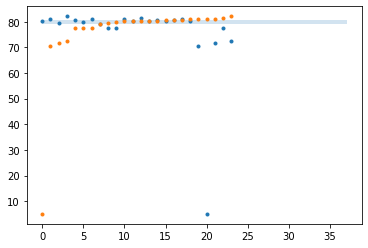

In [320]:
importlib.reload(cbct)
mag= cbct.estimate_magnification(tcal, 24)

### Estimating the Piercing Point: 

Piercing Point is the minima of all the elliptical trajectories. The minor axis for the ellipse at the piercing point is 0. Thus, the strategy applied is to plot a graph of minor axis length versus the height of the ellipse i.e the y-coordinate of the centre of the ellipse. The best linear fit line on being extrapolated gives the y-coordinate of the piercing point. Further using the best linear fit line for the centres of the ellipses, we can obtain the x-coordinate of the piercing point. 

Piercing Point is at:  (880.362045004844, 355.5714734238067)


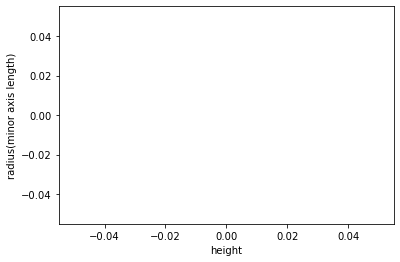

In [326]:
[h_piercing, v_piercing]= cbct.estimate_piercingpoint(e2)

Plotting the various ellipses together in a single graph.

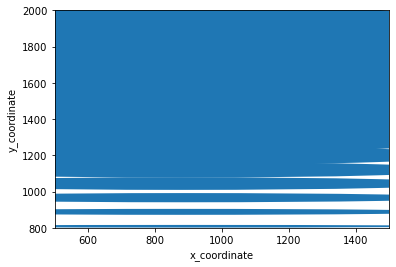

In [168]:
cbct.plot_allellipses(e2)

### Estimating the Source Object Distance (SOD) and the Source Detector Distance (SDD):

This is done by using two similar triangle geometries to calculate the various heights of the beads and hence the SOD and SDD. 
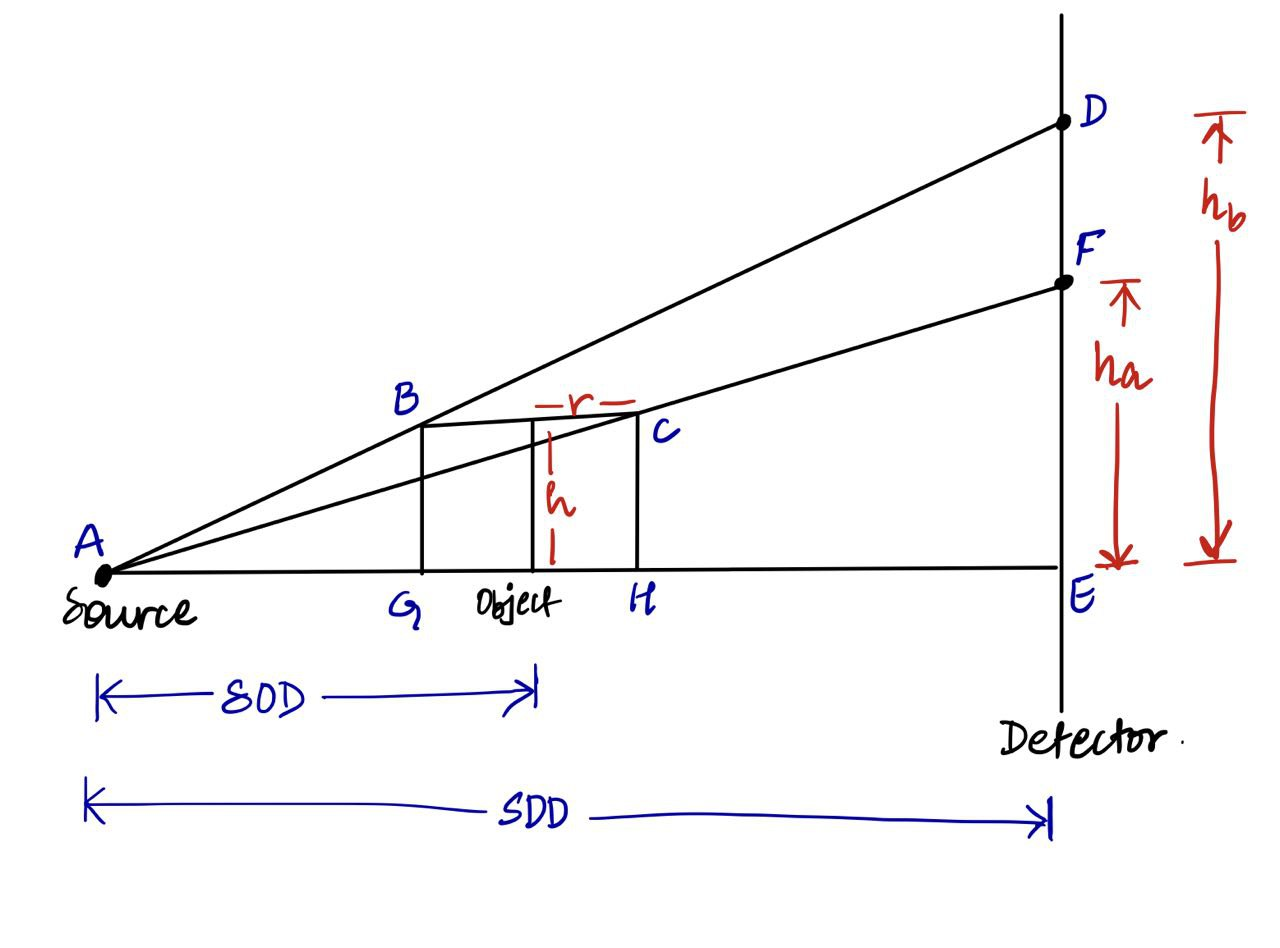 


4 triangles that can be identified from the above are: $\Delta ABG$, $\Delta ADE$, $\Delta ACH$, $\Delta AFE$

The similar triangles' pairs are: $\Delta ABG$ and $\Delta ADE$ , $\Delta ACH$ and $\Delta AFE$

By using similarity, we have the following equations: 

$$ \frac{AG}{AE} = \frac{BG}{DE} $$  and  $$ \frac{AH}{AE} = \frac{CH}{FE} $$ 

$$ \frac{SOD - r}{SDD} = \frac{h}{h_{b}} $$  and  $$ \frac{SOD + r}{SDD} = \frac{h}{h_{a}} $$ 

After extracting value of $ h $, we equate the two equations as follows: 

$$ h_{b}(SOD - r) = h_{a}(SOD + r) $$

$$ \frac{(SOD - r)}{(SOD + r)} = \frac{h_{a}}{h_{b}} $$

$$ SOD \cdot h_{b} - r \cdot h_{b} = SOD \cdot h_{a} + r \cdot h_{a}$$

$$ SOD \cdot (h_{b} - h_{a}) = r \cdot (h_{b} + h_{a}) $$

$$ SOD = \frac{(h_{b} + h_{a}) \cdot r}{(h_{b} - h_{a})} $$

Using magnification we find earlier we calculate the $ SDD $ using the following relation between $ SDD, SOD $ and $ magnification (mag) $ :

$$mag = \frac{SDD}{SOD}$$

$$ SDD = mag \cdot SOD $$

An additional factor of 1.08 is included in the calculation of SOD to account of the error in the final answer.

In [337]:
importlib.reload(cbct)
mag=10.54
cbct.estimate_sod_sdd(tcal, e2, 748,mag,factor=1.1)

h: -49.893, SOD: 99.88, SDD: 1052.72, magn: 10.54, ha: 51.48, hb: 64.22
h: -49.885, SOD: 96.51, SDD: 1017.21, magn: 10.54, ha: 41.63, hb: 52.33
h: -49.719, SOD: 96.39, SDD: 1015.99, magn: 10.54, ha: 31.75, hb: 39.93
h: -49.801, SOD: 96.60, SDD: 1018.16, magn: 10.54, ha: 22.13, hb: 27.81
h: -49.819, SOD: 97.24, SDD: 1024.89, magn: 10.54, ha: 12.10, hb: 15.19
h: 49.758, SOD: 92.55, SDD: 975.44, magn: 10.54, ha: 7.49, hb: 9.51
h: 49.760, SOD: 94.26, SDD: 993.52, magn: 10.54, ha: 17.26, hb: 21.82
h: 49.771, SOD: 95.01, SDD: 1001.42, magn: 10.54, ha: 26.89, hb: 33.93
h: 49.655, SOD: 93.84, SDD: 989.10, magn: 10.54, ha: 36.39, hb: 46.06
h: 49.686, SOD: 95.12, SDD: 1002.57, magn: 10.54, ha: 45.80, hb: 57.78
h: 49.706, SOD: 95.38, SDD: 1005.32, magn: 10.54, ha: 55.60, hb: 70.09
h: 49.688, SOD: 94.89, SDD: 1000.19, magn: 10.54, ha: 65.27, hb: 82.39
h: 49.655, SOD: 95.09, SDD: 1002.25, magn: 10.54, ha: 75.19, hb: 94.86
h: 49.606, SOD: 95.88, SDD: 1010.61, magn: 10.54, ha: 85.07, hb: 107.12
h: 49

{'sod': 94.43435443822325,
 'sdd': 995.3380957788729,
 'magnification': 10.539999999999997,
 'sd_sod': 4.587418858159353,
 'sd_sdd': 48.35139476499957}

### Sample Reconstruction: 

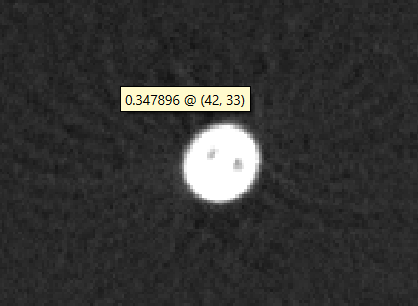

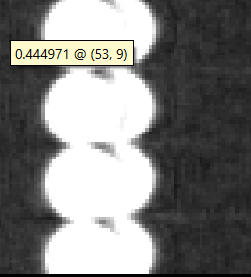



# Workbench

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as im
import amglib.readers as io
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import h_maxima
import skimage.morphology.greyreconstruct as gr
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors
from skimage.color      import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from skimage.measure import label, regionprops, regionprops_table

In [325]:
e2

[[878.652052697349,
  331.82804514715053,
  826.5690654854444,
  45.8347398460074,
  -0.0007491639107726095],
 [878.809197195779,
  410.0133867570523,
  824.6221653722123,
  38.52304738041126,
  -0.0006108725197264686],
 [877.2736049947861,
  490.1535524254284,
  826.4998576108663,
  29.42418689082689,
  -0.0006090252304113008],
 [865.4709336440468,
  568.3657344882361,
  827.2526880280693,
  20.455374234097718,
  -0.0004860484578577129],
 [885.3488166931019,
  649.8289142138403,
  829.3676482125971,
  11.10553394512979,
  -0.00045302315247708336],
 [897.6864390375031,
  809.133175411307,
  827.7031180798328,
  7.266205379589605,
  -0.00015260186913762988],
 [875.1547884483012,
  888.5578171649898,
  828.8015737314951,
  16.40256674696447,
  -0.0003760842563780142],
 [890.3532853640012,
  966.761178041726,
  826.2307097619246,
  25.32732503731927,
  -0.0004002608498613569],
 [877.6454471408157,
  1044.5720422985205,
  827.5191598001994,
  34.763399949050005,
  -0.0004267429268827172],
